# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка библиотек 

In [1]:
pip install --upgrade pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных и осмотр

In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv') # для загрузки на платформе
    print('Данные загружены корректно')
except (FileNotFoundError, OSError):
    try:
        df = pd.read_csv('C:\\Users\\Downloads\\toxic_comments.csv') # локально, нужно указать свой путь
        print('Данные загружены корректно')
    except (FileNotFoundError, OSError):
        print('Произошла ошибка при загрузке')

Данные загружены корректно


In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [7]:
df.isna().sum() # Хоть и эта инфомайция отражается в методе инфо, всё равно проведем её.

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Явных пустот нет, но если вдруг есть неявные, "пробельные комментарии" - для этого отсортируем текст в алфавитном порядке.

In [8]:
display(df.sort_values('text'))

,Unnamed: 0,text,toxic
119018,119123,"""""""",1
135898,136036,"wikipedia-watch.org ALL TRUE 100% LOL!!!""",0
93236,93328,!\n\nI won't stop! LOCK IT UP A$$HOLE,1
124303,124432,"!\n\nIt is now inside your bones, your head. H...",1
9283,9296,!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want ...,1
...,...,...,...
13661,13676,"➥the Epopt]] 14:00, 8 May",0
139227,139379,北京 \n\nI am going to reinstate the weatherbox ...,0
156089,156248,"只, is it correctly written in the picture of t...",0
132439,132576,这是什么意思？\n\nYou have been blocked from editing....,0


Похоже, что ничего обнаружить не удалось.

In [9]:
df.duplicated().sum() # Проверим наличие явных дубликатов

0

In [10]:
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[1] / df['toxic'].value_counts()[0]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

0.11310497114027364

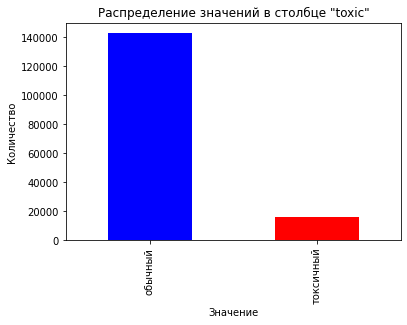

In [11]:
# Получаем значения для столбца 'toxic'
toxic_counts = df['toxic'].value_counts()

# Строим график
toxic_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Распределение значений в столбце "toxic"')
plt.xlabel('Значение')
plt.ylabel('Количество')

# Изменяем подписи под столбцами
plt.xticks([0, 1], ['обычный', 'токсичный'])

plt.show()



Вывод по осмотру:
    Данные загружены успешно, всего в них почти 160 тысяч строк, токсичных комментариев почти в 10 раз меньше чем нетоксичных. Поскольку перед нами стоит задача классификации, разбалансировка классов может быть проблемой для обучения моделей. Есть несколько способов это "исправить". Мы можем уравнять веса, либо уравнять количество записей относящихся к разным классам. и Здесь тоже 2 пути. Либо мы "урезаем" преобладающий класс, либо создаем "фальш-записи" меньшего класса. Но у нас достаточно много записей, а далее нам предстоит лемматизация - а это как праивило отнимает много времени, поэтому во втором варианте мы выберем уменьшение преобладающего класса.
    P.S. Плюс ко всему, по семейным обстоятельствам (прибавление), я не могу выполнить проект локально (сейчас в разъездах, то тут то там), поэтому буду стараться выбирать пути наименьшего сопротивления, чтобы платформа не зависала.

## Подготовка

Напишем функцию лемматизации и применим её.

### Разбиение на выборки, лемматизация

In [12]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


In [13]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
lemmatizer = WordNetLemmatizer()
def predproc(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
    text = ' '.join(text)
    return text

def get_wordnet_pos(word):
    """Возвращает соответствующий POS-тег для использования с WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

In [15]:
df['lemm_text'] = df['text'].apply(predproc)

Разобьем выборку по отношению 60% - тренировочная, 20% - валидационная, 20% - тестовая. Количество кросс-валидаций примем равным 3, данных в выборке немало, ускорим таким образом процесс.

In [16]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=42)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 113408)
(31858, 113408)
(31859, 113408)


In [17]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.691834063238491
CPU times: user 48.9 s, sys: 55.4 s, total: 1min 44s
Wall time: 1min 44s


Мне из всех вариантов балансировки классов кажется наиболее приемлемым срезание преобладающего, но начнем с изменения весов.

### Изменение весов класса

In [18]:
%%time

classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)

F1 на CV с балансированными классами 0.7409337890673419
CPU times: user 34.1 s, sys: 38.4 s, total: 1min 12s
Wall time: 1min 12s



<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
    Извини, пойду по пути наименьшего сопротивления, не могу сейчас уделить время на эксперименты. На днях иду забирать своих из роддома. Нужно все подготовить к их приезду. Как станет по свободнее, попробую сделать проект с нуля и уже с BERT. Но сейчас, просто удалю часть с ресемплированием. Тем более что дальше, я использую развесовку, а ресемлирование больше было для тренировки.
    
    
   Удаленная часть 
  ### Ресемплирование с уменьшением класса обычных комментариев  
    
toxic_comments_train = df.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))
del count_tf_idf
del stopwords
    

classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)
    
    
График
    
classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия с ресемплированием', color='red', linewidth=2, alpha=0.5)

</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Проводить кросс-валидацию на upsampled/downsampled данных – некорректно, так как баланс классов нарушен. Напомню, что внутри кросс-валидации происходит разбиение переданной в нее выборки на треин и валидацию. 
    
В случае upsampling получается так, что в треин и в валидацию (внутри кросс-валидации) вообще попадают одни и те же объекты. 

* Можно попробовать реализовать подход из статьи: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html .
* Можно использовать параметр class_weights.
* Можно отдельно выделить валидационную выборку и изменить баланс только на треине.
* Можно вообще ничего не делать, то есть не бороться с дисбалансом. 
* Каждый их способов выше может как улучшить, так и ухудшить качество. Это поле для экспериментов.
</div>

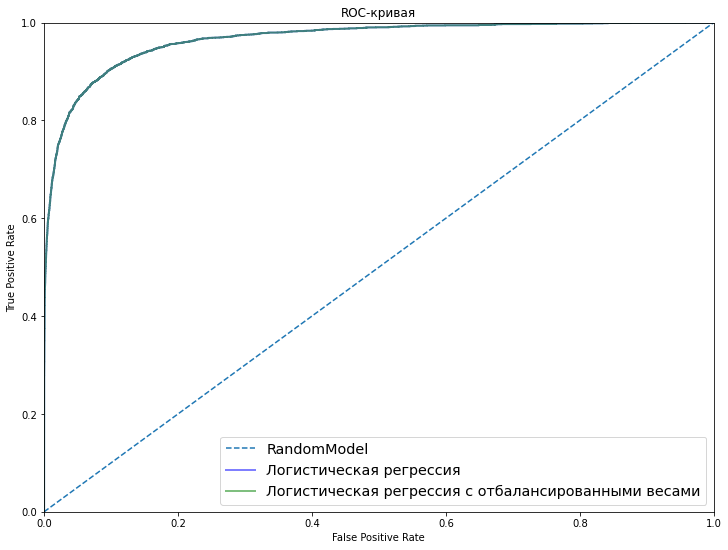

In [19]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия', color='blue', linewidth=2, alpha=0.5)

classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='Логистическая регрессия с отбалансированными весами', color='green', linewidth=2, alpha=0.5)


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [20]:
index = ['LogisticRegression',
         'LogisticRegression с балансировкой весов']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.691834,0.720666,0.965778
LogisticRegression с балансировкой весов,0.740934,0.720666,0.965778


Всё-таки выберем балансировку весов для построения моделей. Результат метрики f1 выглядит более стабильным в этом случае.

## Обучение

### Логистическая регрессия

In [21]:
%time
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':['balanced']}]


print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs

Лучшие параметры:

{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}

0.700849 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.700819 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.700693 for {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.740899 for {'C': 1, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.740934 for {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.740934 for {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
0.753904 for {'C': 10, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.754285 for {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.753904 for {'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}



In [ ]:
%%time
cv_f1_LR = max(means)
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

### Дерево решений

In [23]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[42],
                'class_weight':['balanced', None]}]


print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)


Лучшие параметры:

{'class_weight': None, 'max_depth': 46, 'random_state': 42}

0.611386 for {'class_weight': 'balanced', 'max_depth': 30, 'random_state': 42}
0.610284 for {'class_weight': 'balanced', 'max_depth': 32, 'random_state': 42}
0.610790 for {'class_weight': 'balanced', 'max_depth': 34, 'random_state': 42}
0.614629 for {'class_weight': 'balanced', 'max_depth': 36, 'random_state': 42}
0.618880 for {'class_weight': 'balanced', 'max_depth': 38, 'random_state': 42}
0.621232 for {'class_weight': 'balanced', 'max_depth': 40, 'random_state': 42}
0.622397 for {'class_weight': 'balanced', 'max_depth': 42, 'random_state': 42}
0.627259 for {'class_weight': 'balanced', 'max_depth': 44, 'random_state': 42}
0.628308 for {'class_weight': 'balanced', 'max_depth': 46, 'random_state': 42}
0.618911 for {'class_weight': 'balanced', 'max_depth': 48, 'random_state': 42}
0.611035 for {'class_weight': 'balanced', 'max_depth': 50, 'random_state': 42}
0.680803 for {'class_weight': None, 'max_depth': 3

In [24]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6986886326538917
F1 на валидации 0.6934599926927293
CPU times: user 20.5 s, sys: 70.9 ms, total: 20.6 s
Wall time: 20.6 s


### SGDC

In [28]:
%%time

classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[42],
                'class_weight':['balanced']}]


print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)


Лучшие параметры:

{'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 42}

0.730136 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 42}
0.707067 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 42}
0.746743 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 42}
0.732069 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 42}
0.709333 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 42}
0.744850 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'random_state': 42}
0.645947 for {'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'hinge', 'random_state':

In [29]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7495001339451098
F1 на валидации 0.7404985696771558
CPU times: user 1.72 s, sys: 113 ms, total: 1.83 s
Wall time: 1.84 s


### Вывод по обучению

Исходя из возможностей которые на данный момент обладает исполнитель (то есть я), установлено, что лучшая модель из трех рассмотренных это логистическая регрессия. Проведем исследования на тестовых данных, чтобы убедиться, что она отвечает запросам заказчика.

Метрики LogisticRegression
ROC AUC: 0.9654428765218748
F1: 0.7554061952074811
Precision: 0.7053206002728513
Recall: 0.8131487889273357
Accuracy: 0.9474559779026335



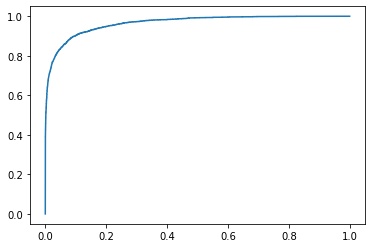

In [27]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

## Вывод

В процессе работы над проектом были импортированы необходимые библиотеки и загружены данные. В процессе осмотра критических проблем с данными обнаружено не было (не было ни пропусков, ни дубликатов, формат определен верно). Основная проблема была с дисбалансов целевого признака - токсичных комментариев было намного меньше (почти в 10 раз), чем обычных. После сравнительного анализа двух методик компенсации этой проблемы, было принято решение проводить балансировку весов при построении моделей. Ввиду ограничений времени и невозможности выполнить проект локально, было обучены 3 простейших модели, тем не менее 1 из них показала результаты, которые соответствовали требованиям заказчика ( метрика F1 выше 0.75), а другая совсем немного не дотянула до необходимого показателя (F1 =0,749), что тоже не плохой вариант для рассмотрения, тем более что обучение и выдача предсказаний у модели SGDC проходило немного быстрее, чем у логистической регрессии. По итогу всей работы, из представленных моделей заказчику стоит порекомендовать логистическую регрессию, её метрика оказалась наивысшей.
Тем не менее, данное решение, можно назвать в каком-то смысле временным, на данный момент существуют текстовые трансформеры (BERT например), которые при наличии достаточного аппаратного обеспечения могут показать значительно лучшие результаты, но в данном исследовании рассмотреть их не представилось возможным.